In [7]:
#importing the necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
#loading the images
image_paths = ["Panorama_1.jpeg", "Panorama_2.jpeg", "Panorama_3.jpeg"]

In [9]:
# ORB Detector
orb = cv2.ORB_create()

In [10]:
# Storing keypoints and descriptors
keypoints_list = []
descriptors_list = []
images = []

In [11]:
# Function for detecting keypoints
def detect_keypoints(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return image, keypoints, descriptors

In [12]:
# Processing each image
for path in image_paths:
    img, kps, des = detect_keypoints(path)
    images.append(img)
    keypoints_list.append(kps)
    descriptors_list.append(des)

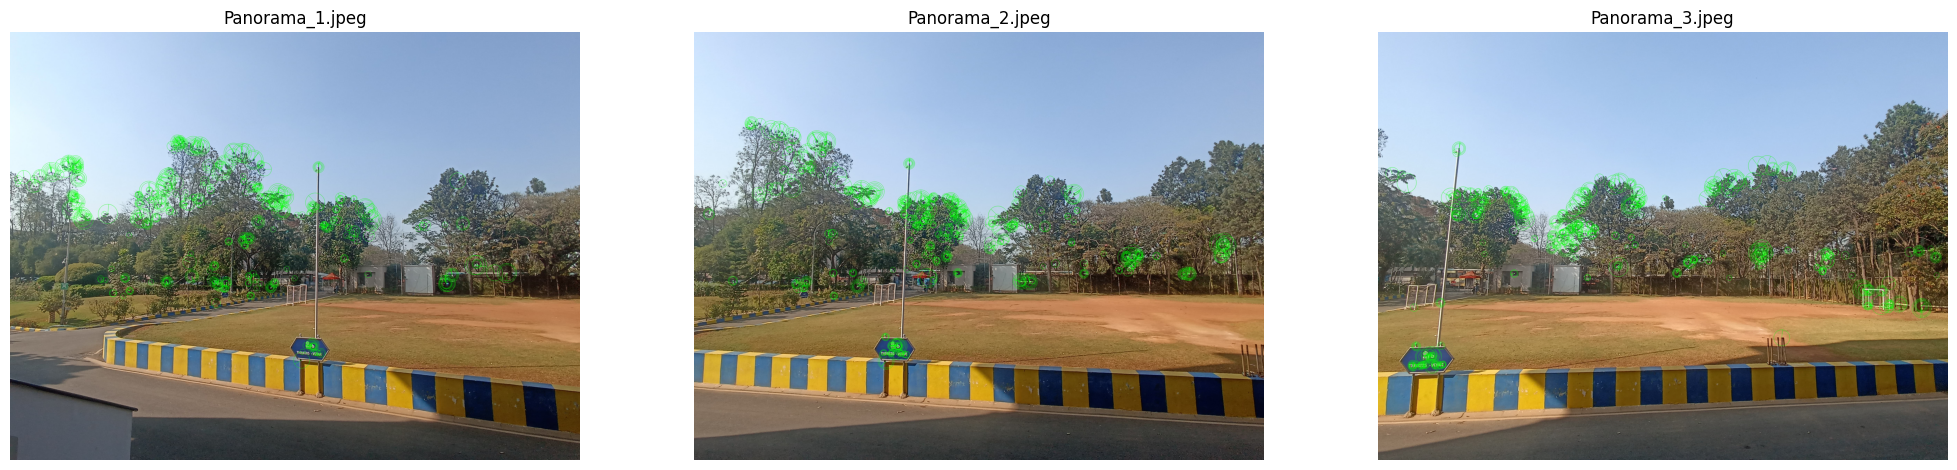

In [13]:
# Displaying images with keypoints (with enhanced feature point markings)
fig, axes = plt.subplots(1, len(images), figsize=(25, 10))
for ax, img, kps, path in zip(axes, images, keypoints_list, image_paths):
    img_with_keypoints = cv2.drawKeypoints(img, kps, None, color=(0, 255, 0), 
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    ax.set_title(path.split('/')[-1])
    ax.axis("off")
plt.show()

In [14]:
# Image Stitching Function
def stitch_images(images, keypoints_list, descriptors_list):
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    panorama = images[0]
    
    for i in range(1, len(images)):
        matches = matcher.match(descriptors_list[i - 1], descriptors_list[i])
        matches = sorted(matches, key=lambda x: x.distance)  # Sort by best matches
        
        # Extracting matched keypoints
        src_pts = np.float32([keypoints_list[i - 1][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        # Computing Homography
        H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        
        # Extracting dimensions of images
        h1, w1 = panorama.shape[:2]
        h2, w2 = images[i].shape[:2]
        
        # Warping the images to align with panorama
        warped_img = cv2.warpPerspective(images[i], H, (w1 + w2, h1))
        warped_img[0:h1, 0:w1] = panorama  # Overlay images
        panorama = warped_img
    
    # Croping black areas to improve the final output
    gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    panorama = panorama[y:y+h, x:x+w]
    
    return panorama

In [15]:
# Performing Image Stitching
stitched_image = stitch_images(images, keypoints_list, descriptors_list)

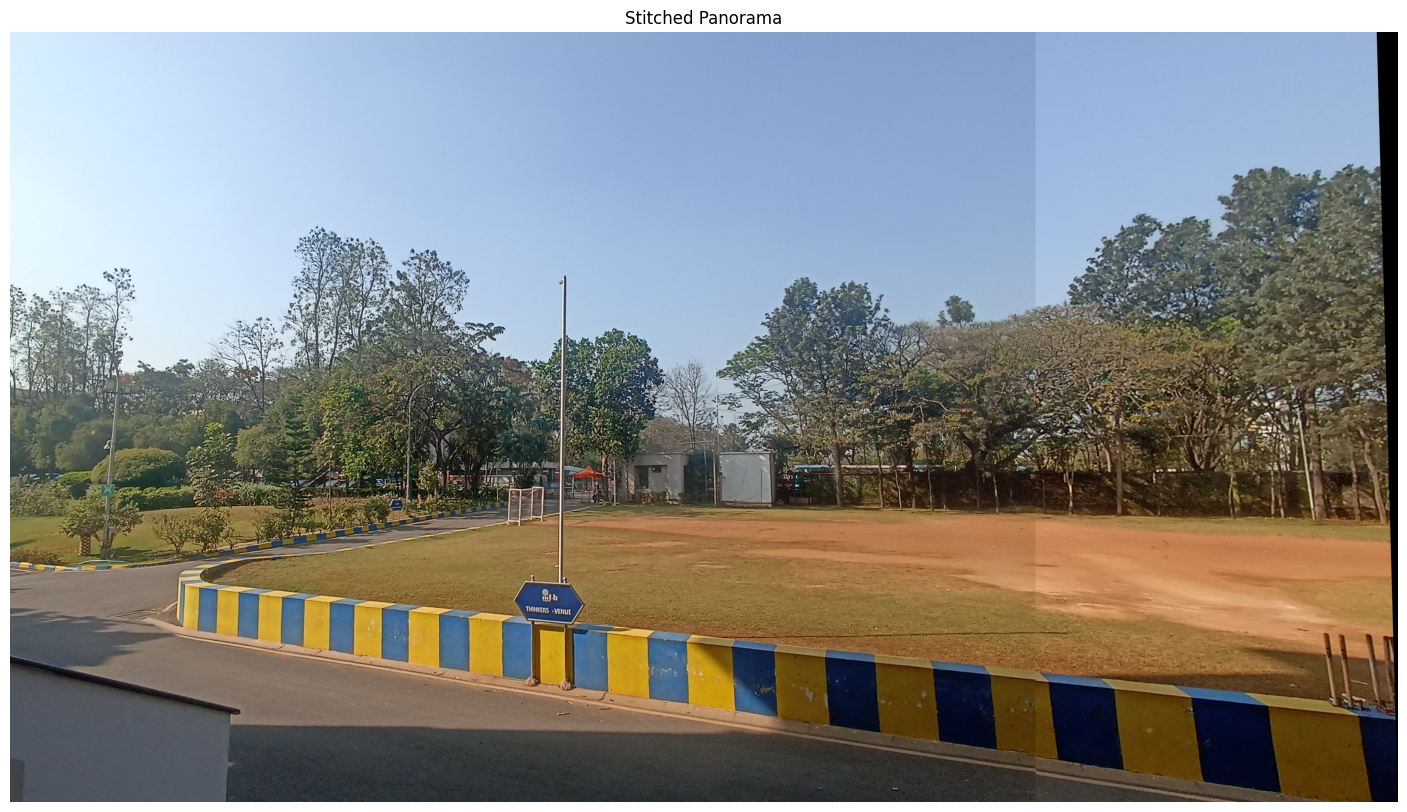

In [16]:
# Displaying Final Stitched Panorama
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Stitched Panorama")
plt.show()